# Introduction

## Imports

In [2]:
! pip install statsmodels
! pip install textstat
! pip install textblob
! pip install scikit-learn
! pip install xgboost
! pip install shap
! pip install tensorflow
! pip install tqdm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import textstat
from textblob import TextBlob

## Import the dataset

In [4]:
df_fake = pd.read_csv('data/Fake.csv')
df_real = pd.read_csv('data/True.csv')

# Wrangling

## Functions

### Building a wrapper for subjectivity/objectivity

the library we found for some of the functions doesn't work unless you initialize an object first so thats why we do this to apply the function

In [5]:
def subjectivity_objectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

def sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

### Ridiculous LSTM model (as an xgboost feature)

In [6]:
df_fake['real'] = 0
df_real['real'] = 1
df = pd.concat([df_fake,df_real])
df_save = df.copy()

In [7]:
import tensorflow.keras as Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import random
import tensorflow as tf

SEED = 42 # Choose any integer you like for the seed

# Set seeds for different libraries
random.seed(SEED)       # Python's built-in random
np.random.seed(SEED)      # NumPy
tf.random.set_seed(SEED)  # TensorFlow/Keras global seed


X = df_save.copy()['text']
y = df_save['real']

texts = df_save.copy()['text'].values
labels = df['real'].values

vocab_size = 10000 # only keep top 10k

# create the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')

# fit the tokenizer on the texts
tokenizer.fit_on_texts(texts)


word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens.")

# Convert text sequences to integer sequences
sequences = tokenizer.texts_to_sequences(texts)


# Example of a sequence
print(texts[0])
print(sequences[0])


Found 138022 unique tokens.
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! H

In [8]:
# pad the sequences
max_length = 125
padded_sequences = pad_sequences(sequences, maxlen=max_length,
                                 padding='post', truncating='post')


# Example of a padded sequence
print(padded_sequences[0])


[  71   16   83 1469   41 2502   56  225    5 1692   64   85    6  686
   15   28    8  536   14   43    3  428    5 8618   58    3   20 3213
 8777    6    2  152 4878  718  102  123    2  109  968  245 1048   43
   83   53  467    3   92    6   14 1469   41   92   15   19   74  112
 4679    1 2959    6    1   34  191    3 2502   56    4  182  978  353
 3213 8777    6  111    2  152 4878  718  102  123    5 1692    6 4254
   64   85   37 1683 6289 1038 1230   40   23    5  385   85   11  161
   19   74  112 4679    1 2959    6    1   34  191    3 2502   56    4
  182  978  353 3213 8777    6  111    2  152 4878  718  102  123]


In [37]:
model = Sequential(
    [
        Embedding(input_dim=vocab_size + 1, output_dim=256, input_length=max_length),
        LSTM(100),
        Dense(100, activation='relu'),
        Dropout(0.2),
        # Dense(12, activation='relu',name='twelve_features_layer'),
        # Dropout(0.2),
        Dense(1, activation='sigmoid'),
    ]
)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(padded_sequences, labels, epochs=2, batch_size=128, validation_split=0.2)
model.summary()

Epoch 1/2


/Users/leogordon/Desktop/DIS/Big Data Env/Assignments/Final_Project/.venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


281/281 ━━━━━━━━━━━━━━━━━━━━ 53s 184ms/step - accuracy: 0.8138 - loss: 0.4064 - val_accuracy: 0.8595 - val_loss: 0.6744
Epoch 2/2
281/281 ━━━━━━━━━━━━━━━━━━━━ 55s 195ms/step - accuracy: 0.9173 - loss: 0.2507 - val_accuracy: 0.8906 - val_loss: 0.3964


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 125, 256)       │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,139,773 (31.05 MB)

 Trainable params: 2,713,257 (10.35 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,426,516 (20.70 MB)

In [10]:
def predict_text(text):
    """
    Predict the probability of a text being real or fake."""
    # Convert the text to a sequence
    sequence = tokenizer.texts_to_sequences([text])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    # Predict using the model
    prediction = model.predict(padded_sequence)
    return prediction[0][0]  # Return the predicted probability
predict_text("The quick brown fox jumps over the lazy dog.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


np.float32(0.00011370798)

### build a dictinoary of functions and names

do this to avoid redundant code during the runs for both dataframes. Could have avoided by just merging them but this is also cool

In [11]:
function_dict = {

    # complexity approaches
    'coleman_liau':textstat.coleman_liau_index,
    'smog':textstat.smog_index,

    # sentence length
    'sentence_length':textstat.avg_sentence_length,

    # subjectivity/objectivity
    'subjectivity':subjectivity_objectivity,

    # sentiment
    'sentiment':sentiment,

    # word count
    'word_count':textstat.lexicon_count,

    # syllable count
    'syllable_count':textstat.syllable_count,

    # flesch reading ease
    'flesch_reading_ease':textstat.flesch_reading_ease,

    # flesch-kincaid grade level
    'flesch_kincaid_grade':textstat.flesch_kincaid_grade,

    # lstm-output
    # 'lstm_output':predict_text


}

In [35]:
# for df in [df_fake,df_real]:
#     for j in function_dict.keys():
#         df[j] = df['text'].apply(function_dict[j])

from tqdm.auto import tqdm # Use tqdm.auto for better compatibility (Jupyter/console)
# from tqdm.pandas impo  /rt tqdm_pandas
import pandas as pd # Assuming you are using pandas DataFrames

# Register tqdm with pandas. Do this once at the beginning of your script/notebook.
# tqdm_pandas() 

# Assume df_fake, df_real, and function_dict are already defined

# It's helpful to iterate through (name, df) pairs for clearer descriptions
dataframes_to_process = [('df_fake', df_fake), ('df_real', df_real)]

# Wrap the outer loop with tqdm
for df_name, df in tqdm(dataframes_to_process, desc="Processing DataFrames"):

    for j in function_dict.keys():
        print(f"Processing {j} for {df_name}")
        df[j] = df['text'].apply(function_dict[j])


# After the loops complete, df_fake and df_real will have the new columns

Processing DataFrames:   0%|          | 0/2 [00:00<?, ?it/s]

Processing coleman_liau for df_fake
Processing smog for df_fake
Processing sentence_length for df_fake
Processing subjectivity for df_fake
Processing sentiment for df_fake
Processing word_count for df_fake
Processing syllable_count for df_fake
Processing flesch_reading_ease for df_fake
Processing flesch_kincaid_grade for df_fake


Processing DataFrames:  50%|█████     | 1/2 [01:31<01:31, 91.64s/it]

Processing coleman_liau for df_real
Processing smog for df_real
Processing sentence_length for df_real
Processing subjectivity for df_real
Processing sentiment for df_real
Processing word_count for df_real
Processing syllable_count for df_real
Processing flesch_reading_ease for df_real
Processing flesch_kincaid_grade for df_real


Processing DataFrames: 100%|██████████| 2/2 [02:52<00:00, 86.15s/it]


In [42]:
y_pred_probabilities = model.predict(padded_sequences)
# df_save['lstm_output'] = y_pred_probabilities

1404/1404 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step


### Combine the dataframes

In [49]:
df_fake['real'] = 0
df_real['real'] = 1
df = pd.concat([df_fake,df_real])
df_save = df.copy()
df_save['lstm_output'] = y_pred_probabilities
df_save.to_csv('data/df.csv',index=False)

## IMPORTANT RELOAD DATA

In [50]:
df = pd.read_csv('data/df.csv')

### drop the non-classification targets

In [51]:
df = df.drop(columns=['title','text','subject','date'])
df

,real,coleman_liau,smog,sentence_length,subjectivity,sentiment,word_count,syllable_count,flesch_reading_ease,flesch_kincaid_grade,lstm_output
0,0,9.05,11.8,17.0,0.599895,0.082132,492,738,62.68,8.7,0.008092
1,0,11.95,12.9,16.9,0.334098,-0.005004,305,519,45.86,11.1,0.016363
2,0,11.02,11.7,16.1,0.541969,-0.012345,579,882,63.59,8.4,0.010128
3,0,11.19,13.0,17.6,0.394086,-0.023118,441,699,53.61,10.2,0.011423
4,0,8.59,11.5,21.0,0.495222,-0.011722,420,611,58.62,10.3,0.012755
...,...,...,...,...,...,...,...,...,...,...,...
44893,1,11.43,13.2,19.9,0.447884,0.219279,458,743,51.28,11.1,0.978257
44894,1,13.05,13.8,20.7,0.077778,0.022222,124,218,33.54,13.7,0.973350
44895,1,11.26,14.1,19.9,0.426609,0.054382,318,510,51.28,11.1,0.660115
44896,1,10.51,13.0,22.7,0.377753,0.021993,204,313,56.89,11.0,0.998033


In [53]:
df.dtypes

real                      int64
coleman_liau            float64
smog                    float64
sentence_length         float64
subjectivity            float64
sentiment               float64
word_count                int64
syllable_count            int64
flesch_reading_ease     float64
flesch_kincaid_grade    float64
lstm_output             float64
dtype: object

## EDA

### PCA Graph by Class

looks like there are some clear outliers in this dataset

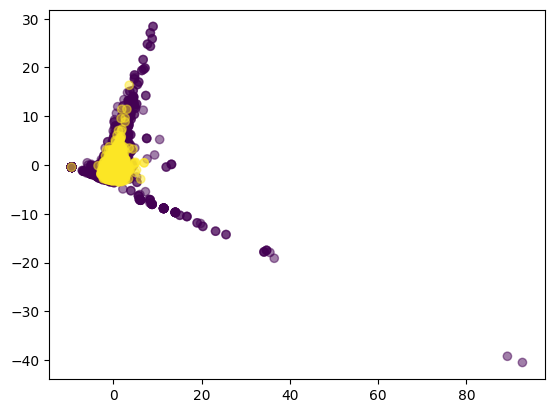

In [54]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# drop the real column
df_X = df.copy().drop(columns=['real'])
df_y = df.copy()['real']

# reassign (has no actual use)
X = np.array(df_X)
y=np.array(df_y)

# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# apply the pca
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

# wrangle the data
X_pca_df = pd.DataFrame(data=X_pca, columns=['pc1', 'pc2'])
final_df = pd.concat([X_pca_df, pd.DataFrame(y, columns=['real'])], axis=1)
# final_df = final_df.sample(frac=1).reset_index(drop=True)

# plot
plt.scatter(final_df['pc1'],final_df['pc2'],c=final_df['real'],alpha=.5)

#### finding pca outliers

In [55]:
final_df['pc1'].sort_values(ascending=False)

9358     92.699619
15508    89.297545
15507    36.462753
12139    35.484463
21870    34.711457
           ...    
12512    -9.478408
16415    -9.478408
12511    -9.478408
19033    -9.478408
19317    -9.478408
Name: pc1, Length: 44898, dtype: float64

### t-SNE

above looked bad so trying a t-SNE

In [19]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# drop the real column
df_X = df.copy().drop(columns=['real'])
df_y = df.copy()['real']

# reassign (has no actual use)
X = np.array(df_X)
y=np.array(df_y)

# scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# apply the pca
tsne = TSNE(n_components=2,random_state=42)

tsne.fit(X)
X_tsne = tsne.fit_transform(X)

KeyboardInterrupt: 

In [20]:
# wrangle the data
X_tsne_df = pd.DataFrame(data=X_tsne, columns=['pc1', 'pc2'])
final_df = pd.concat([X_tsne_df, pd.DataFrame(y, columns=['real'])], axis=1)
final_df = final_df.sample(frac=1).reset_index(drop=True)

# plot
plt.scatter(final_df['pc1'],final_df['pc2'],c=final_df['real'],alpha=0.25)

NameError: name 'X_tsne' is not defined

### Worst articles

when you look at some of these they make no sense, and just are really long sentences, or articles that make no sense. These are also all fake news. This implies that there is bad fake data.

In [21]:
df['smog'].sort_values(ascending=False).head(25)

18429    32.7
16042    32.7
10531    32.7
18117    29.5
10119    29.5
2639     29.0
17422    25.5
21862    25.5
15828    25.5
35196    24.6
35292    24.6
30758    23.8
39138    23.7
29448    23.7
30778    23.2
30729    22.8
40793    22.6
18135    22.5
10145    22.5
19775    22.1
12686    22.1
21055    21.7
16794    21.7
14566    21.7
9003     21.6
Name: smog, dtype: float64

In [22]:
df_save[df_save.index == 18429].iloc[0]['real'],df_save[df_save.index == 18429].iloc[0]['text']

(np.int64(0),
 'Tennessee lawmakers have something to say to their counterparts in California and it s perfect! We could love this more Tennessee hits back at the loony state that banned all state travel to places that they think don t have the right policy in place. The response is epic: Whereas, California has passed legislation banning state sponsored travel to Tennessee and certain other states; andWhereas, the ban stems from legislation enacted by Tennessee that allows counselors to refer patients to other counselors who can better meet their goals, which the California State Legislature has judged to be morally reprehensible; andWhereas, California s attempt to influence public policy in our state is akin to Tennessee expressing its disapproval of California s exorbitant taxes, spiraling budget deficits, runaway social welfare programs, and rampant illegal immigration; andWhereas, Tennessee is pleasantly surprised that California will not be sending its economic development teams

In [23]:
df_save[df_save.index == 10119].iloc[0]['real'],df_save[df_save.index == 10119].iloc[0]['text']

(np.int64(0),
 'An unidentified black Trump supporter blasted the Cudahy City, CA Council members over her objections to  racist  sanctuary cities. Her argument was based on her belief that sanctuary cities offer certain protections and benefits that are not even being offered to legal American citizens.Watch her amazing take down of the bleeding hearts who put lawbreaking foreign citizens before taxpaying and unemployed American citizens: Cities and CountiesCaliforniaAlameda County Berkley Contra Costa County Los Angeles County Los Angeles Monterey County Napa County Orange County Orange County Riverside County Sacramento County San Bernardino County San Diego County San Francisco County San Mateo County Santa Ana Santa Clara County Santa Cruz County Sonoma CountyColoradoArapahoe County Aurora Boulder County Denver County Garfield County Grand County Jefferson County Larimer County Mesa County Pitkin County Pueblo County Routt County San Miguel County Weld CountyConnecticutEast Haven 

In [24]:
df_save[df_save.index == 2639].iloc[0]['real'],df_save[df_save.index == 2639].iloc[0]['text']

(np.int64(0),
 'In another of Donald Trump s whine rests, the Dictator in Chief accused the media of not reporting terrorist attacks. On Tuesday, Trump released the list of  unreported terrorist attacks,  which not surprisingly, have been extensively covered by the media. Yes, it s sad that lies from the White House are no longer surprising. What is surprising, though, is how the list was written. It was either done in a sleep deprived flurry from Trump or some drunken monkeys got ahold of a computer.You have to give the White House credit. For complete BS, the list is rather extensive. Here it is; see if you can find what s wrong.TIMELINE: September, 2014   December, 2016 NUMBER OF ATTACKS: 78MELBOURNE, AUSTRALIA September, 2014 TARGET: Two police officers wounded in knife attack ATTACKER: Abdul Numan HaiderTIZI OUZOU, ALGERIA September, 2014 TARGET: One French citizen beheaded ATTACKER: Jund al-Khilafah in AlgeriaQUEBEC, CANADA October, 2014 TARGET: One soldier killed and one wounded

In [25]:
df_save[df_save.index == 17422].iloc[0]['real'],df_save[df_save.index == 17422].iloc[0]['text']

(np.int64(0),
 'Wow! What a list of accomplishments! The problem is that these accomplishments are rotten to the core. Just read a few and you ll get a taste of the corruption and Chicago style politics transplanted to D.C. via Obama. Not pretty!Law and Justice  First President to Violate the War Powers Act (Unilaterally Executing American Military Operations in Libya Without Informing Congress In the Required Time Period   Source: Huffington Post)  First President to Triple the Number of Warrantless Wiretaps of U.S. Citizens (Source: ACLU)   First President to Sign into Law a Bill That Permits the Government to  Hold Anyone Suspected of Being Associated With Terrorism Indefinitely, Without Any Form of Due Process. No Indictment. No Judge or Jury. No Evidence. No Trial. Just an Indefinite Jail Sentence  (NDAA Bill   Source: Business Insider)   First President to Refuse to Tell the Public What He Did For Eight (8) Hours After Being Informed That a U.S. Ambassador Was Facing Imminent Dea

In [26]:
df_save[df_save.index == 11715].iloc[0]['real'],df_save[df_save.index == 11715].iloc[0]['text']

(np.int64(0), 'UPDATE VIDEO: Language alert:')

### best articles

In [27]:
df_save[df_save['real'] == 1].sort_values(by='smog',ascending=True).head(25)

,title,text,subject,date,real,coleman_liau,smog,sentence_length,subjectivity,sentiment,word_count,syllable_count,flesch_reading_ease,flesch_kincaid_grade
14642,Suspicious object found with body in Stockholm...,STOCKHOLM (Reuters) - A man was found dead on ...,worldnews,"November 16, 2017",1,11.27,0.0,35.5,0.485000,0.095000,71,108,43.90,16.0
17001,Putin says Russia will respond in kind if U.S....,"SOCHI, Russia (Reuters) - Russia will respond ...",worldnews,"October 19, 2017",1,15.38,0.0,26.5,0.290909,0.042273,53,101,19.20,17.2
2236,Trump says he has not thought about firing Rus...,"BEDMINSTER, N.J. (Reuters) - U.S. President Do...",politicsNews,"August 10, 2017",1,12.08,0.0,35.5,0.532282,0.146691,71,116,35.44,17.1
4944,"FBI, NSA chiefs to testify on Trump wiretap cl...",WASHINGTON (Reuters) - Leaders of the House of...,politicsNews,"March 15, 2017",1,13.65,0.0,45.5,0.125000,0.125000,91,153,16.83,22.2
11052,Obama's legislative aide Fallon departs: White...,WASHINGTON (Reuters) - President Barack Obama ...,politicsNews,"January 29, 2016",1,12.49,0.0,37.5,0.125000,0.125000,75,128,24.95,19.1
19613,China says upholds peaceful resolution of Nort...,BEIJING (Reuters) - China supports a peaceful ...,worldnews,"September 20, 2017",1,11.49,0.0,28.5,0.202381,-0.023810,57,94,42.55,14.4
15502,Islamic State claims responsibility for attack...,CAIRO (Reuters) - Islamic State has claimed re...,worldnews,"November 7, 2017",1,13.36,0.0,48.0,0.375000,0.000000,48,83,14.30,23.2
17014,London will remain leading financial center: P...,LONDON (Reuters) - London will remain the worl...,worldnews,"October 19, 2017",1,12.20,0.0,41.5,0.158333,0.030000,83,127,37.81,18.3
971,White House continues to cooperate with specia...,WASHINGTON (Reuters) - Charges brought against...,politicsNews,"October 30, 2017",1,17.58,0.0,24.5,0.130804,0.016518,49,92,21.23,16.4
19595,"At least 10 dead, 92 missing in eastern Congo ...",ABIDJAN (Reuters) - At least 10 people have di...,worldnews,"September 20, 2017",1,12.54,0.0,34.0,0.175000,-0.165000,68,111,36.97,16.6


In [28]:
df_save[df_save.index == 6354].iloc[1]['real'],df_save[df_save.index == 6354].iloc[1]['text']

(np.int64(1),
 'WASHINGTON (Reuters) - U.S. President Barack Obama surprised Vice President Joe Biden on Thursday by awarding him the Presidential Medal of Freedom with Distinction in an emotional White House ceremony that celebrated their partnership over eight years in office. “This is an extraordinary man,” Obama said of his friend and running mate at a surprise ceremony with staff, family and friends of the vice president.  “For the past eight years, he could not have been a more devoted or effective partner in the progress that we’ve made.” Biden, who was unaware that the ceremony would take place,  became visibly moved when Obama said he would bestow on him the highest civil honor in the United States.  It will be the last such award that Obama gives before he and Biden leave office on Jan. 20.  “I had no inkling,” Biden, 74, said after receiving the medal. “I get a lot of credit I don’t deserve,” he said, proceeding to give a roughly 20-minute impromptu speech thanking Obama and

## Analysis

### train test split

In [56]:
from sklearn.model_selection import train_test_split

# drop the real column
df_X = df.copy().drop(columns=['real'])
df_y = df['real']

# reassign (has no actual use)
X = np.array(df_X)
y=np.array(df_y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)


### Logistic Regression

In [57]:
# robust standard errors because of heteroskedasticity

model = sm.Logit(y_train, X_train).fit(cov_type='HC1')
model.summary()

Optimization terminated successfully.
         Current function value: 0.129289
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                33673
Model:                          Logit   Df Residuals:                    33663
Method:                           MLE   Df Model:                            9
Date:                Sun, 20 Apr 2025   Pseudo R-squ.:                  0.8132
Time:                        22:15:35   Log-Likelihood:                -4353.6
converged:                       True   LL-Null:                       -23307.
Covariance Type:                  HC1   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0744      0.011     -7.019      0.000      -0.095      -0.054
x2             0.1034      0.009     11.801      0.000       0.086       0.121
x3             0.0537      0.013      4.155      0.000       0.028       0.079
x4            -3.1707      0.272    -11.667      0.000      -3.703      -2.638
x5            -0.2725      0.281     -0.968      0.333      -0.824       0.279
x6             0.0072      0.001      8.532      0.000       0.006       0.009
x7            -0.0044      0.001     -8.533      0.000      -0.005      -0.003
x8            -0.0427      0.002    -26.711      0.000      -0.046      -0.040
x9            -0.1193      0.030     -3.956      0.000      -0.178      -0.060
x10            8.0538      0.106     76.324      0.000       7.847       8.261
==============================================================================
"""

### overfit detection

we didn't discuss any of the assumptions of LR so we have to check for overfitting

In [58]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

c_matrix = np.array([[0,0],
            [0,0]])

for i in range(0,len(y_test)):
    y_val = int(y_test[i])
    y_hat_val = int(y_pred[i])
    c_matrix[y_val][y_hat_val] += 1

# compute the accuracy
print(f'accuracy of the model: {(c_matrix[0][0] + c_matrix [1][1]) / c_matrix.sum() * 100}%')

# compute the f1 score

# pres is TP/(TP + FP)
pres = c_matrix[1][1] / (c_matrix[1][1] + c_matrix[0][1])

# recall is TP / (TP + FN)
recall = c_matrix[1][1] / (c_matrix[1][1] + c_matrix[1][0])
print
# f1 score
f1_score = (2 * pres * recall) / (pres + recall)
print(f'f1_score: {f1_score}')
print(f'confusion matrix: {c_matrix}')

accuracy of the model: 96.41870824053453%
f1_score: 0.9613907030349597
confusion matrix: [[5818   77]
 [ 325 5005]]


In [59]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df.copy().drop(columns=['real'])
y = df['real']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, n_estimators=1000, max_depth=10, learning_rate=0.1, )
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/Users/leogordon/Desktop/DIS/Big Data Env/Assignments/Final_Project/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:15:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.970489977728285
Confusion Matrix:
 [[4667   66]
 [ 199 4048]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      4733
           1       0.98      0.95      0.97      4247

    accuracy                           0.97      8980
   macro avg       0.97      0.97      0.97      8980
weighted avg       0.97      0.97      0.97      8980



### SHAP importance

/var/folders/zk/32z6vfcs7xjb7_k4dwp2r63c0000gn/T/ipykernel_2992/2404237598.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X.columns)


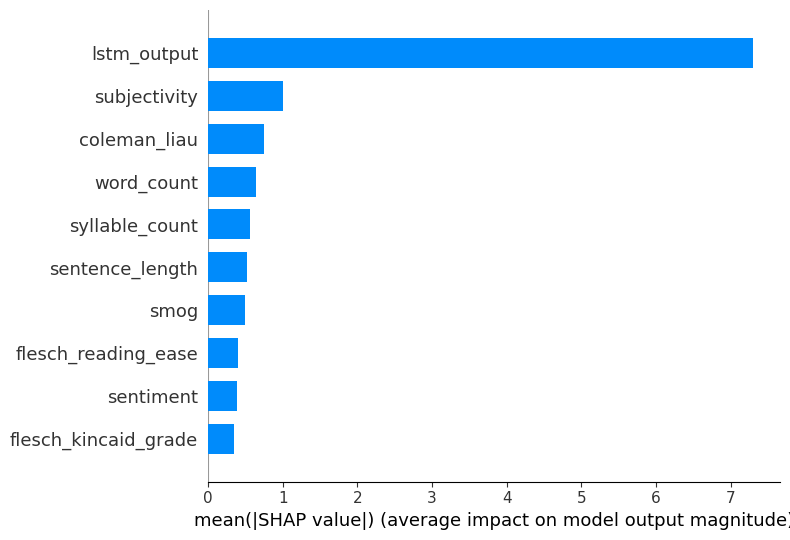

/var/folders/zk/32z6vfcs7xjb7_k4dwp2r63c0000gn/T/ipykernel_2992/2404237598.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_subset, feature_names=X.columns)


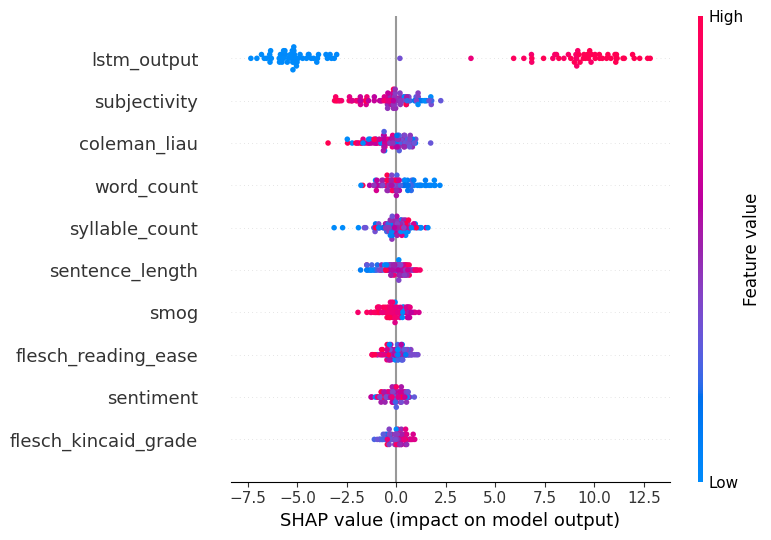

In [60]:
# calculate shap values
import shap
explainer = shap.Explainer(model)
X_test_subset = X_test.sample(100, random_state=41)
shap_values = explainer(X_test_subset)
shap.summary_plot(shap_values, X_test_subset, plot_type="bar", feature_names=X.columns)
shap.summary_plot(shap_values, X_test_subset, feature_names=X.columns)
shap.initjs()